In [29]:
import csv
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps
import pickle
import random
import pandas as pd

In [30]:
mode = "wopn"

(31, 4)


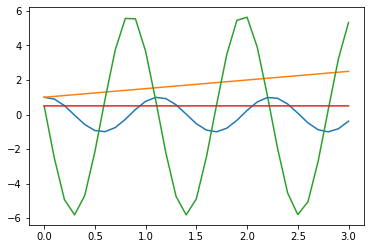

In [31]:
X = pd.read_csv('X_'+mode+'.csv', sep=',',header=None)
# print(X.values)
X = np.array(X.values)
# print(X)
X = np.delete(X, 0, axis= 0)
X = np.array(X, dtype=np.float64)
# print(X)
for x in X:
    for y in range(len(x)):
        for z in range(len(X)):
            X[z][y] = float(X[z][y])
# print(X)
print(X.shape)
t_end = 3
tt = np.linspace(0, t_end, X.shape[0])
plt.plot(tt, X)

(31, 4)


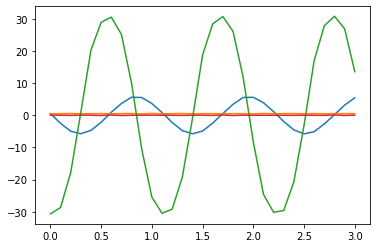

In [32]:
L = pd.read_csv('L_'+mode+'.csv', sep=',',header=None)
L = np.array(L.values)
L = np.delete(L, 0, axis= 0)
L = np.array(L, dtype=np.float64)
for x in L:
    for y in range(len(x)):
        for z in range(len(L)):
            L[z][y] = float(L[z][y])
# print(L)
print(L.shape)
plt.plot(tt, L)

In [33]:
library_functions = [
    lambda x : x,
    lambda x : np.sin(x),
    lambda x : np.cos(x)
]
library_function_names = [
    lambda x : x,
    lambda x : 'sin(' + x + ')',
    lambda x : 'cos(' + x + ')',

]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)
differentiation_method = ps.FiniteDifference(order=2)
# feature_library = ps.PolynomialLibrary(degree=9)
feature_library = custom_library
optimizer = ps.SR3(threshold=0.2)

In [34]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["phi", "x", "phidot","xdot"]
)
dt= t_end/(X.shape[0]-1)
model.fit(X, x_dot=L, t=dt, multiple_trajectories=False)
model.print()

phi' = 0.546 phi + 0.305 x + 1.000 phidot + 379760596.918 xdot + -0.609 sin(phi) + -424305044.432 sin(xdot) + 0.343 cos(x) + 15431454.657 cos(xdot)
x' = -0.045 x + -102847165.119 xdot + 114911514.264 sin(xdot) + -0.060 cos(x) + -4179585.656 cos(xdot)
phidot' = 0.809 phi + -2.070 x + -2921202703.898 xdot + -37.400 sin(phi) + 0.178 sin(phidot) + 3263851056.143 sin(xdot) + 0.342 cos(phi) + -2.275 cos(x) + -118703584.197 cos(xdot)
xdot' = 0.227 x + 151970050.519 xdot + -169795643.221 sin(xdot) + 0.247 cos(x) + 6175307.395 cos(xdot)


In [35]:
t_test = np.linspace(0, 3, X.shape[0])
random.seed(12)
x0_test = [1,1,0.5,0.5]
x_test = X
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 0.497983


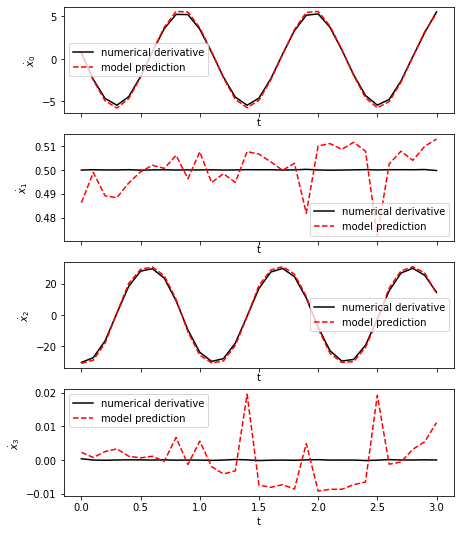

In [36]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)
#t_test = np.linspace(0, 15, 3000)


fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))

for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))

fig.show()

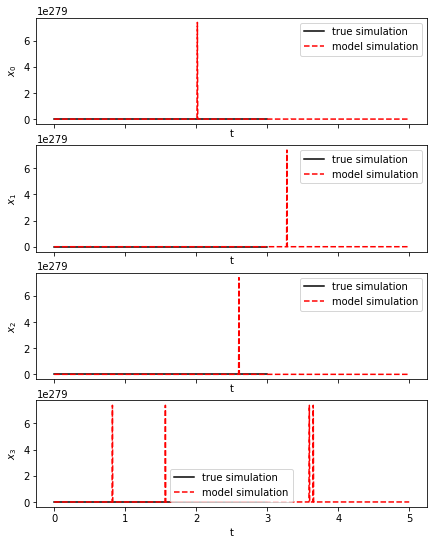

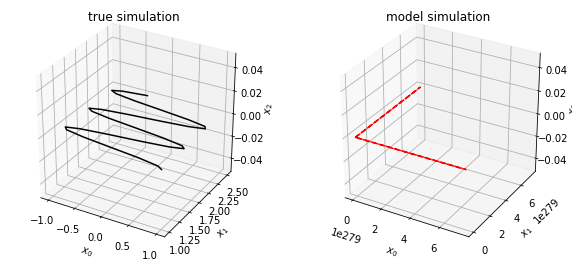

In [37]:
# Evolve the new initial condition in time with the SINDy model

t_evolve = np.linspace(0, 5, 1000)
x_test_sim = model.simulate(x0_test, t_evolve)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_evolve, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1],  'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()